# Präsenzversuch zum Laval-Rotor

Name:  Noah Michel 
Datum:  08.02.2024
Gruppe: 18

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit:
Wie erstellt man ein Campbell-Diagramm?

## Erster Versuch: Prüfstand #X
Hier werden Sie die Messergebnisse des ersten Prüfstands auswerten. Die Auswertung des zweiten Prüfstands kann analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.
Bitte ergänzen Sie im Titel der Markdown-Zellen die Nummer des Prüfstands

###  Versuchsaufbau
- Bild des Prüfstands:

<img src="Image/IMG_20240130_103326.jpg" width="500">

- Beschreibung des Aufbaus, gehen Sie auf die Anzahl der Scheiben und deren Gewicht ein:
Der Prüstand besteht nur aus einer Scheibe.

### Versuchsauswertung

In [1]:
import os
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import importlib
import json

from functions import m_postprocessing

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1. Einlesen der Mess- und Metadaten

Beim Einlesen der Mess- und Metadaten geben wir Ihnen bereits eine Struktur vor. Es bietet sich an diese zu verwenden, ist aber nicht zwingend erforderlich.

##### 1.a) Angabe der Pfade und Dateinamen
Passen Sie die unten stehenden Pfade an, indem Sie `None` ersetzen.

In [2]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240130_101321_lavalrotor_18_04"
)  # path to the folder with H5-file and metadata
filename = "data_20240130_101321_lavalrotor_18_04.h5"  # name of the H5-file

##### 1.b) Preparieren der Metadaten
Wenn Sie die Pfade oben korrekt definiert haben, dann müssen Sie hier nichts anpassen. Schauen Sie sich die Struktur von `setup_dict` an und die zurückgegebenen IDs `uuid_acceleration` und `uuid_motor_rpm`.

In [3]:
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)


{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240130_101321_lavalrotor_18_04/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823ce-82b9-6d4e-a621-60af4e6f5cc1": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240130_101321_lavalrotor_18_04/1ee823ce-82b9-6d4e-a621-60af4e6f5cc1.json"
  },
  "1ee823b6-50dc-6670-aea5-35f6dd717e83": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240130_101321_lavalrotor_18_04/1ee823b6-50dc-6670-aea5-35f6dd717e83.json"
  },
  "1ee8239b-46ec-63dc-8aa4-b8751ac37fd3": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240130_101321_lavalrotor_18_04/1ee8239b-46ec-63dc-8aa4-b8751ac37fd3.json"
  },
  "1ee823d6-3d20-6332-83f5-6876b760dcf3": {
    "type": "sensor",
  

##### 1.c) Initialisieren der Datenstrukturen für die Messdaten
Hier wird der Vektor `interpolation_points` mit Stützstellen für die Interplation der Messdaten für alle Drehzahlen erzeugt. Dieses vereinfacht später die Darstellung des Campbell-Diagramms enorm.

Initialisieren Sie Datenstrukturen um alle nötigen Daten für das Campbell-Diragramm abspeichern zu können, verwenden Sie dazu ggf. `interpolation_points`.

In [4]:
importlib.reload(m_postprocessing)

measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

#H5 Datei öffnen

f = h5py.File("measurement_data/data_20240130_101321_lavalrotor_18_04/data_20240130_101321_lavalrotor_18_04.h5")

#Leere Listen erstellen wo die Werte eingespeichert werden:

acc_x = []
acc_y = []
acc_z = []
time = []
rpm = []

#Werte in leere Listen einspeichern:

for i in f:
    acc_x.append(np.array(f.get(str(i) + "/RawData/" + str(uuid_acceleration) + "/acceleration_x")))
    acc_y.append(np.array(f.get(str(i) + "/RawData/" + str(uuid_acceleration) + "/acceleration_y")))
    acc_z.append(np.array(f.get(str(i) + "/RawData/" + str(uuid_acceleration) + "/acceleration_z")))

for i in f:
    time.append(np.array(f.get(str(i) + "/RawData/" + str(uuid_acceleration) + "/timestamp")))
    
for i in f:
    rpm.append(np.array(f.get(str(i) + "/RawData/" + str(uuid_motor_rpm) + "/motor_rpm")))


#### 2. Verarbeitung der Messdaten

Verarbeiten Sie die Messdaten für alle untersuchten Drehzahlen mit `m_postprocessing.get_vec_accel()`, `m_postprocessing.interpolation()` und `m_postprocessing.my_fft_scaled()`.

In [5]:
importlib.reload(m_postprocessing)  # reload functions

#leere Listen erstellen:

list_betrag = []
list_interpolation = []
am_fr = []

#Betrag, Interpolation und ffr-Werte in Listen speichern.

for i in range(len(acc_x)):
    list_betrag.append(m_postprocessing.get_vec_accel(acc_x[i], acc_y[i], acc_z[i]))
    
for i in range(len(acc_x)):
    list_interpolation.append(m_postprocessing.interpolation(time[i], list_betrag[i], interpolation_points))

for i in range(len(acc_x)):
    am_fr.append(m_postprocessing.my_fft_scaled(list_interpolation[i], interpolation_points))

# aus am_fr zwei Listen erstellen um Amplituden und Frequenzen zu trennen.
    
amplitude = []
frequenz = []

for i in range(len(acc_x)):
    amplitude.append(am_fr[i][0])
    frequenz.append(am_fr[i][1])

#### 3. Darstellung mittels Campbell-Diagramm

Erzeugen Sie hier ein Campbell-Diagramm aus den Messdaten.

Text(0, 0.5, 'Frequenz')

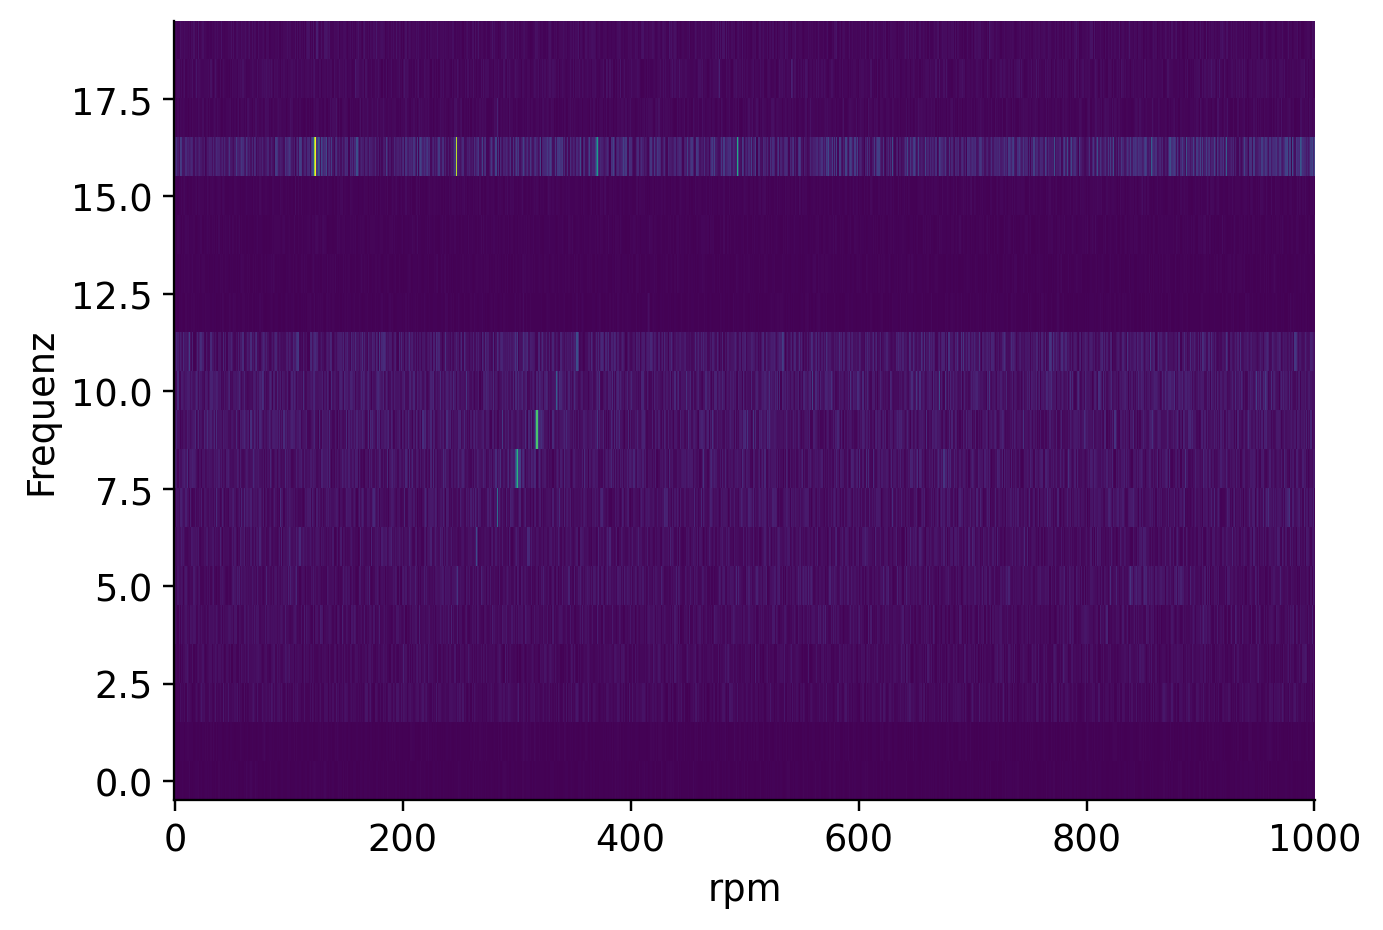

In [6]:
# Mit Plt show das Campbell-Diagramm erstellen:

plt.imshow(amplitude, interpolation='none', origin='lower', aspect='auto')

plt.xlabel("rpm")
plt.ylabel('Frequenz')

In [7]:
## Zweiter Datensatz: Prüfstand #3

#### 1. Einlesen der Mess- und Metadaten

In [8]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_100928_lavalrotor_01_02"
)  # path to the folder with H5-file and metadata
filename = "data_20240102_100928_lavalrotor_01_02.h5"  # name of the H5-file

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

importlib.reload(m_postprocessing)

measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

f = h5py.File("measurement_data/data_20240102_100928_lavalrotor_01_02/data_20240102_100928_lavalrotor_01_02.h5")

acc_x = []
acc_y = []
acc_z = []
time = []
rpm = []

for i in f:
    acc_x.append(np.array(f.get(str(i) + "/RawData/" + str(uuid_acceleration) + "/acceleration_x")))
    acc_y.append(np.array(f.get(str(i) + "/RawData/" + str(uuid_acceleration) + "/acceleration_y")))
    acc_z.append(np.array(f.get(str(i) + "/RawData/" + str(uuid_acceleration) + "/acceleration_z")))

for i in f:
    time.append(np.array(f.get(str(i) + "/RawData/" + str(uuid_acceleration) + "/timestamp")))
    
for i in f:
    rpm.append(np.array(f.get(str(i) + "/RawData/" + str(uuid_motor_rpm) + "/motor_rpm")))

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cc-06c7-631a-99e2-dc18593ae07a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee823cc-06c7-631a-99e2-dc18593ae07a.json"
  },
  "1ee823b3-32d9-6d20-8261-106b0e021eed": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee823b3-32d9-6d20-8261-106b0e021eed.json"
  },
  "1ee82398-0056-698f-8809-248cede81c54": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee82398-0056-698f-8809-248cede81c54.json"
  },
  "1ee823d3-8511-6a0b-8cd5-972f083673c9": {
    "type": "sensor",
  

#### 2. Verarbeitung der Messdaten

In [9]:
importlib.reload(m_postprocessing)  # reload functions

list_betrag = []
list_interpolation = []

for i in range(len(acc_x)):
    list_betrag.append(m_postprocessing.get_vec_accel(acc_x[i], acc_y[i], acc_z[i]))

for i in range(len(acc_x)):
    list_interpolation.append(m_postprocessing.interpolation(time[i], list_betrag[i], interpolation_points))

am_fr = []

for i in range(len(acc_x)):
    am_fr.append(m_postprocessing.my_fft_scaled(list_interpolation[i], interpolation_points))

amplitude = []
frequenz = []

for i in range(len(acc_x)):
    amplitude.append(am_fr[i][0])
    frequenz.append(am_fr[i][1])

#### 3. Darstellung mittels Campbell-Diagramm

Text(0, 0.5, 'Frequenz')

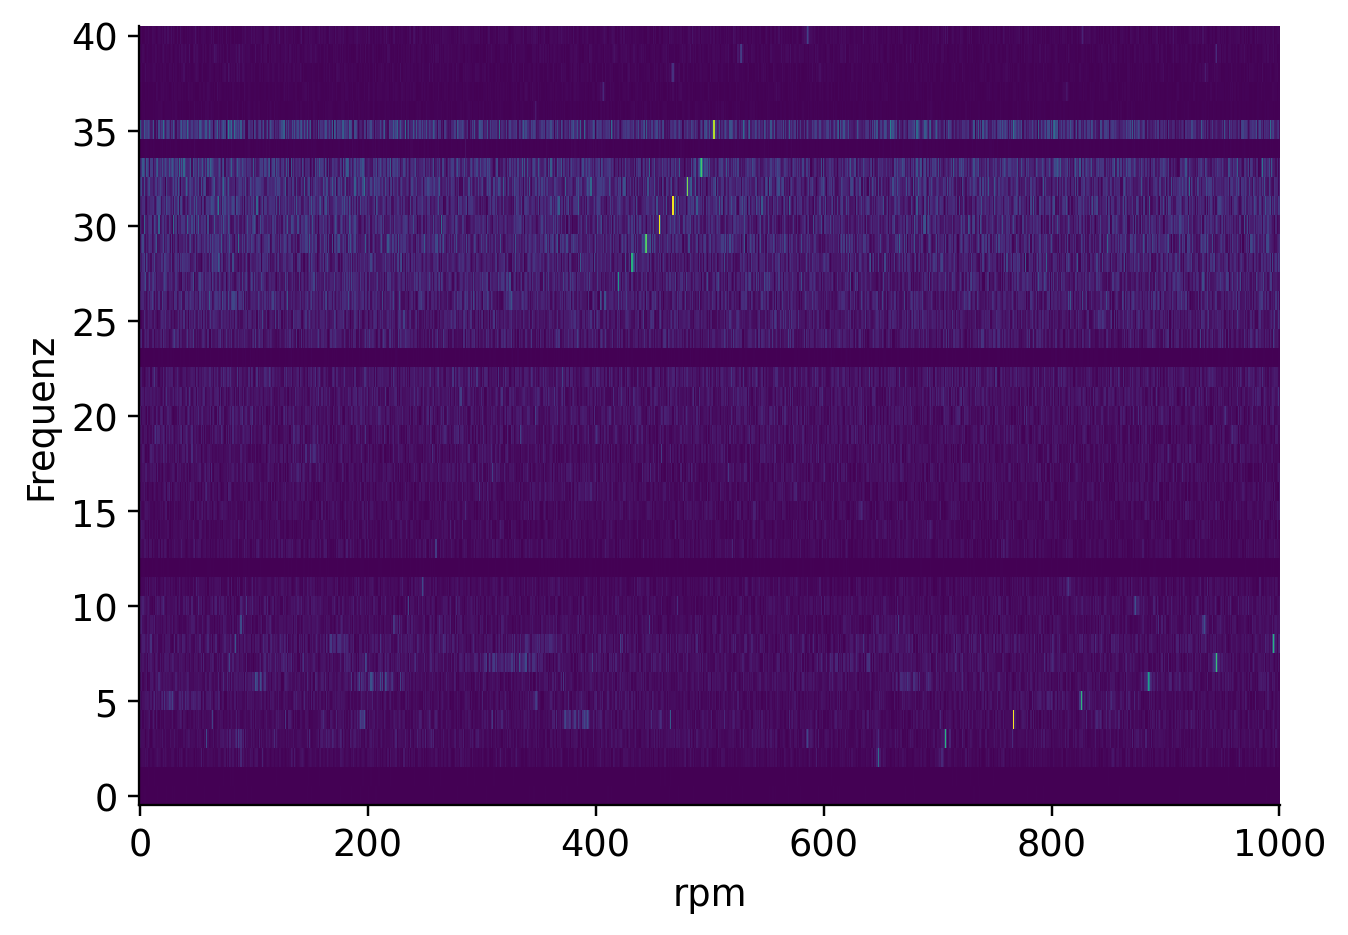

In [10]:
plt.imshow(amplitude, interpolation='none', origin='lower', aspect='auto')

plt.xlabel("rpm")
plt.ylabel('Frequenz')

## Dritter Datensatz: Prüfstand #3

#### 1. Einlesen der Mess- und Metadaten

In [11]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_112539_lavalrotor_01_03"
)  # path to the folder with H5-file and metadata
filename = "data_20240102_112539_lavalrotor_01_03.h5"  # name of the H5-file

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

importlib.reload(m_postprocessing)

measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

f = h5py.File("measurement_data/data_20240102_112539_lavalrotor_01_03/data_20240102_112539_lavalrotor_01_03.h5")

acc_x = []
acc_y = []
acc_z = []
time = []
rpm = []

for i in f:
    acc_x.append(np.array(f.get(str(i) + "/RawData/" + str(uuid_acceleration) + "/acceleration_x")))
    acc_y.append(np.array(f.get(str(i) + "/RawData/" + str(uuid_acceleration) + "/acceleration_y")))
    acc_z.append(np.array(f.get(str(i) + "/RawData/" + str(uuid_acceleration) + "/acceleration_z")))

for i in f:
    time.append(np.array(f.get(str(i) + "/RawData/" + str(uuid_acceleration) + "/timestamp")))
    
for i in f:
    rpm.append(np.array(f.get(str(i) + "/RawData/" + str(uuid_motor_rpm) + "/motor_rpm")))

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cd-7650-61c2-9b01-d4744d892e2a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee823cd-7650-61c2-9b01-d4744d892e2a.json"
  },
  "1ee823b5-5d9b-6f24-9817-906ef09da71d": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee823b5-5d9b-6f24-9817-906ef09da71d.json"
  },
  "1ee8239a-489e-66bc-932e-2587341b8ad5": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee8239a-489e-66bc-932e-2587341b8ad5.json"
  },
  "1ee823d5-1451-6df6-a364-c723014c91a1": {
    "type": "sensor",
  

#### 2. Verarbeitung der Messdaten

In [12]:
importlib.reload(m_postprocessing)  # reload functions

list_betrag = []
list_interpolation = []

for i in range(len(acc_x)):
    list_betrag.append(m_postprocessing.get_vec_accel(acc_x[i], acc_y[i], acc_z[i]))

for i in range(len(acc_x)):
    list_interpolation.append(m_postprocessing.interpolation(time[i], list_betrag[i], interpolation_points))

am_fr = []

for i in range(len(acc_x)):
    am_fr.append(m_postprocessing.my_fft_scaled(list_interpolation[i], interpolation_points))

amplitude = []
frequenz = []

for i in range(len(acc_x)):
    amplitude.append(am_fr[i][0])
    frequenz.append(am_fr[i][1])

#### 3. Darstellung mittels Campbell-Diagramm

Text(0, 0.5, 'Frequenz')

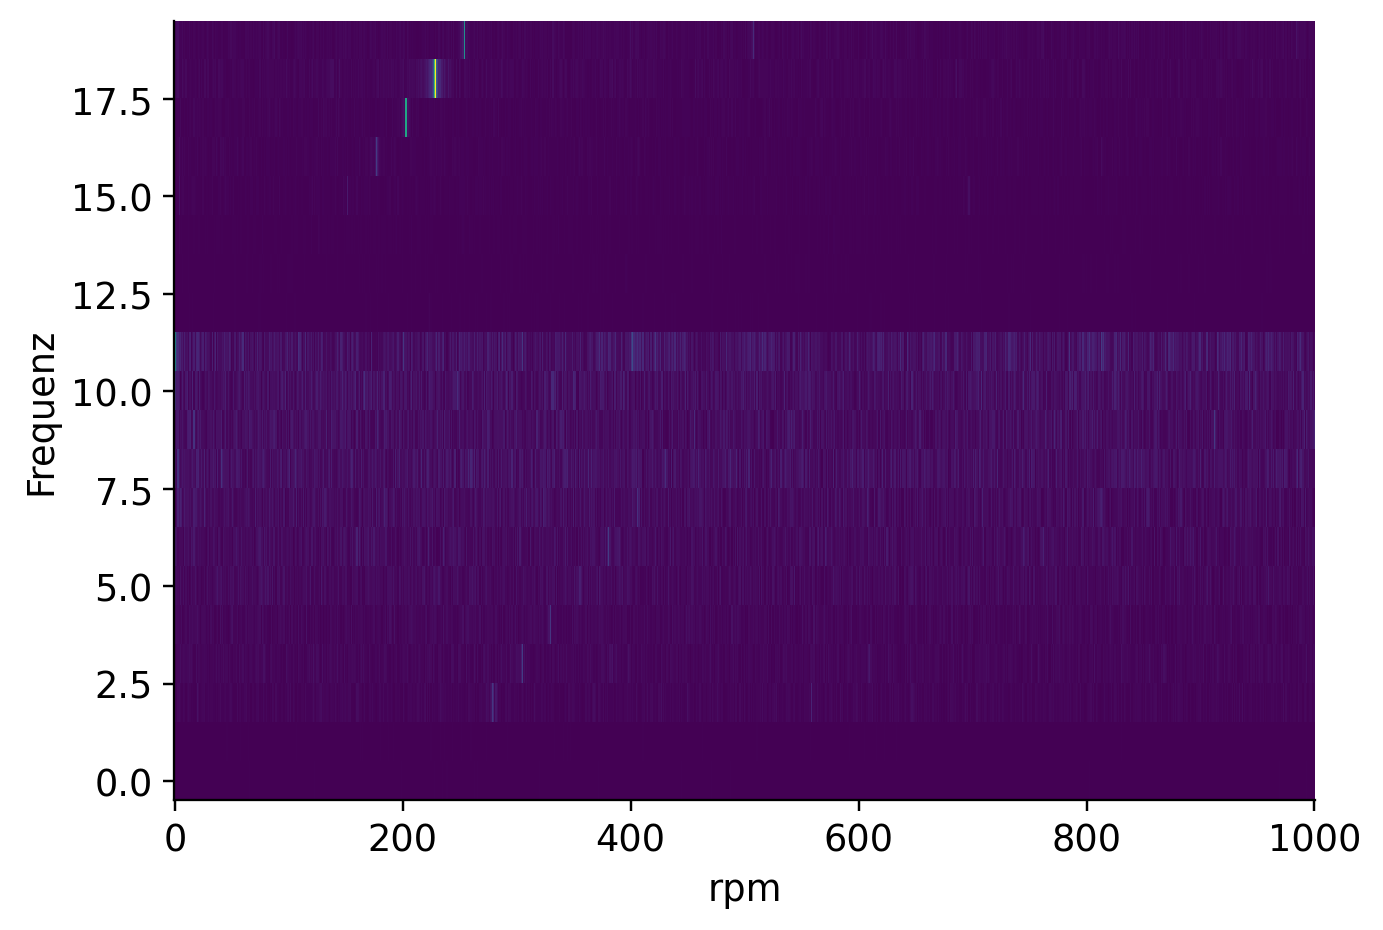

In [13]:
plt.imshow(amplitude, interpolation='none', origin='lower', aspect='auto')

plt.xlabel("rpm")
plt.ylabel('Frequenz')

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Ein Campbell-Diagramm wird bestimmt indem die Amplituden, welche mit der Fourier-Transformation transformiert und anschließlig auch skaliert wurden, mit deren rpm innerhalb ein Diagramm abgebildet werden. Dort kann man dann erkennen wo sich die Eigenfrequenzen befinden.

##### Vergleich der gemessenen mit der analytisch berechneten kritischen Drehzahl
Sie können für den Vergleich, falls benötigt auch Code Cells einfügen.

Bei dem Versuch wo nur eine Scheibe vorhanden ist, vereinfacht sich die Gleichung folgendermaßen:

w = (k/m)^1/2
k ist dabei die Ersatzfedersteifigkeit und m die Masse.

Die Ersatzfedersteifigkeit berechnet sich:

k = (48*E*I)/(L³) = 4,8*10^-3

I = (pi*d^4)/64 = 2,012*10^-10

und damit ist:

w = 0,07

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Leider war ich mir am Ende nicht sicher ob mein Campbell-Diagramm richtig war, weswegen ich auch nicht mehr vergleichen konnte. An sich war die Lehreinheit recht interessant und hat Spaß gemacht.